In [192]:
import numpy as np
import pandas as pd
import math as m
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [2]:
# lectura de los datos
short = pd.read_csv('../dataNuse/short.csv', sep=',', encoding='utf-8', error_bad_lines=False)
nuse1 = pd.read_csv('../dataNuse/nuse_110220.csv', sep=',', encoding='utf-8', error_bad_lines=False)

/home/mike/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
# agregación de columnas y filtrado de los datos nulos
def data_crime(df):
    # filtrado de los datos
    dfo = df[['LONGITUD', 'LATITUD', 'LOCALIDAD', 'COD_UPZ', 'UPZ', 'FECHA','MES','ANIO']].sort_values(by=['COD_UPZ'])
    ##dfo = df[((df['COD_UPZ'] !=  'ND')  & (df['COD_UPZ']  != 'UPZ999'))]
    dfo = dfo[((dfo['COD_UPZ'] !=  'ND')  & (dfo['COD_UPZ']  != 'UPZ999'))]
    dfo.reset_index(inplace=True)
    dfo = dfo.rename(columns={'index':'INDEX_TIME'})
    
    # generando nuevas columnas
    dfo['JORN'] = pd.to_datetime(dfo['FECHA']).dt.hour//6
    dfo['DIA'] = pd.to_datetime(dfo['FECHA']).dt.day
    dfo['DSEM'] = pd.to_datetime(dfo['FECHA']).dt.dayofweek
    dfo['ESDIA'] = [0 if (x==0 or x==3) else 1 for x in dfo['JORN']]
    dfo['NSEM'] = pd.to_datetime(dfo['FECHA']).dt.week
    dfo['FSEM'] = [0 if x<4 else 1 for x in dfo['DSEM']]
    return dfo

# encontra intervalos ancho de banda
def bw_intervals(mts, long, lat):
    
    lt_min, lt_max, lg_min, lg_max = 0, 0, 0, 0
    
    cearth = 40075           # earth circumference in kmss
    onedeg_km = cearth / 360 # 1 degree to kms 
    mt_km = mts / 1000       # mts to kms
    
    deglt = mt_km / onedeg_km              # convert kms to deglat
    deglg = mt_km / m.cos(m.radians(lat))  # convert kms to deglong
        
    if lat < 0:
        
        lt_min = -deglt + lat 
        lt_max = lat + deglt
    else:
        
        lt_min = lat - deglt   
        lt_max = lat + deglt
    
    if long < 0:
        
        lg_min = -deglg + long
        lg_max = long + deglg
    else:
        
        lg_min = long - deglt   
        lg_max = long + deglt
    
    return [lg_min, lg_max], [lt_min, lt_max] 
    

In [79]:
# adecuando el conjunto de datos (dataframe principal)
dfp = data_crime(nuse1)

In [34]:
# Tipos de series de tiempo
# mensual = 0, semanal = 1, diario = 2, dia semana = 3, jornada (dia de la semana) = 4
# jornada todos los dias = 5

# parámetros: df: dataframe, tp: tipo de serie, a: año, ds: día de la semana,
#             jd: jornada en un día específico, jtd: jornada en todos los días.
def data_series(df, tp, a, ds, jd):
    
    dfo = pd.DataFrame()
    serie = list()
    d_ok = False
    j_ok = False
    
    # mensual = 0, semanal = 1, diario = 2 completar
    if tp >= 0 and tp <= 5:
        
        if tp == 0:
            serie = ['MES', 'ANIO']
        if tp == 1:
            serie = ['NSEM','MES', 'ANIO'] 
        if tp == 2:
            serie = ['DIA', 'MES', 'ANIO']
        # 0: lunes, 1: martes, 2: miércoles, 3: jueves, 4: viernes, 5: sábado, 6: domingo
        if tp == 3 and ds != None:
            
            if ds >= 0 and ds <= 6: 
                
                serie = ['DSEM', 'MES', 'ANIO']
                dia_ok = True
            else:
                print('No es hay un día de la semana válido')
                
        if tp == 4 and ds!= None and jd != None:
            
            if (ds >= 0 and ds <= 6) and (jd >= 0 and jd <= 3): 
                
                serie = ['JORN','DSEM', 'NSEM', 'ANIO']
                j_ok = True
            else:
                print('No hay un día o jornada válido')
        
        #if tp == 5 and 
            
        if a == None and len(serie) > 0:
            
            dfo = df.pivot_table(index=serie, values='UPZ', aggfunc='count', 
                        fill_value=0)
        elif len(serie) > 0:
            
            dfo = df[df['ANIO'] == a].pivot_table(index=serie, values='UPZ', aggfunc='count', 
                            fill_value=0) 
        else:
            print('No se pudo construir una serie')
    
    # unstack de acuerdo al tipo de serie   
    for i in range(len(serie)):
        dfo = dfo.unstack()
        
    # removiendo las columnas e índices innecesarios
    if len(dfo) > 0:   
        dfo = dfo.fillna(0).to_frame().rename(columns={0:'EVENTS'})
        dfo.index = dfo.index.droplevel(0)
        dfo = dfo.reset_index() 
        
        # si hay día de la semana
        if tp == 3 and d_ok:
            dfo = dfo[dfo['DSEM'] == ds]

        elif tp == 3 and d_ok == False:
            print('No es posible retornar datos sin un día de la semana especificado')
            dfo = pd.DataFrame()

        if tp == 4 and j_ok:
            dfo = dfo[(dfo['JORN'] == jd) & (dfo['DSEM'] == ds)]
        elif tp == 4 and j_ok == False:
            print('No es posible retornar datos sin una jornada  especificado')
            dfo = pd.DataFrame()
        
    return dfo 

# Tipos de series de tiempo
# mensual = 0, semanal = 1, diario = 2, dia semana = 3, jornada (dia de la semana) = 4
# jornada todos los dias = 5
# t = tipo de serie
def data_time_series(t, a, d, jd, mts, p_lg, pt_lt, df):
    
    # encontrando intervalos de ancho de banda
    bwlong, bwlat = bw_intervals(mts, p_lg, pt_lt)
    # df.rename(columns={'Unnamed: 0': 'COUNT'}, inplace=True)
    # dataframe filtrado por latitud y longitud
    dff = df[((df['LATITUD'] >= bwlat[0]) & (df['LATITUD'] <= bwlat[1])) & 
             ((df['LONGITUD'] >= bwlong[0]) & (df['LONGITUD'] <= bwlong[1]))]

    # dataframe para la serie de tiempo de acuerdo al tipo
    # parámetros: df: dataframe, tp: tipo de serie, a: año, ds: día de la semana,
    #             jd: jornada en un día específico
    dffs = data_series(dff, t, a, d, jd) 
    # return pd.DataFrame(columns=['COUNT'], data=dffg)
    return dffs

In [35]:
x = data_time_series(0, None, 1, 2, 100, -74.07745119017216, 4.604447520159951, dfp)
x

,ANIO,MES,EVENTS
0,2014,1,228.0
1,2014,2,283.0
2,2014,3,306.0
3,2014,4,275.0
4,2014,5,263.0
...,...,...,...
67,2019,8,274.0
68,2019,9,275.0
69,2019,10,260.0
70,2019,11,239.0


In [48]:
f = dfp['FECHA'].iloc[0]
 pd.to_datetime('2018', format='%Y') + \
             pd.to_timedelta(1 + ' days')

2018-01-08 00:00:00 2018-09-08 10:57:27


In [231]:
mes = pd.date_range(start='2013-12', end='2020-01', freq='W').strftime('%Y-%m-%d').to_list()
mes

['2013-12-01',
 '2013-12-08',
 '2013-12-15',
 '2013-12-22',
 '2013-12-29',
 '2014-01-05',
 '2014-01-12',
 '2014-01-19',
 '2014-01-26',
 '2014-02-02',
 '2014-02-09',
 '2014-02-16',
 '2014-02-23',
 '2014-03-02',
 '2014-03-09',
 '2014-03-16',
 '2014-03-23',
 '2014-03-30',
 '2014-04-06',
 '2014-04-13',
 '2014-04-20',
 '2014-04-27',
 '2014-05-04',
 '2014-05-11',
 '2014-05-18',
 '2014-05-25',
 '2014-06-01',
 '2014-06-08',
 '2014-06-15',
 '2014-06-22',
 '2014-06-29',
 '2014-07-06',
 '2014-07-13',
 '2014-07-20',
 '2014-07-27',
 '2014-08-03',
 '2014-08-10',
 '2014-08-17',
 '2014-08-24',
 '2014-08-31',
 '2014-09-07',
 '2014-09-14',
 '2014-09-21',
 '2014-09-28',
 '2014-10-05',
 '2014-10-12',
 '2014-10-19',
 '2014-10-26',
 '2014-11-02',
 '2014-11-09',
 '2014-11-16',
 '2014-11-23',
 '2014-11-30',
 '2014-12-07',
 '2014-12-14',
 '2014-12-21',
 '2014-12-28',
 '2015-01-04',
 '2015-01-11',
 '2015-01-18',
 '2015-01-25',
 '2015-02-01',
 '2015-02-08',
 '2015-02-15',
 '2015-02-22',
 '2015-03-01',
 '2015-03-

In [12]:
A = dfp.FECHA.isin(mes)
B = dfp[A]
B

,INDEX_TIME,LONGITUD,LATITUD,LOCALIDAD,COD_UPZ,UPZ,FECHA,MES,ANIO,JORN,DIA,DSEM,ESDIA,NSEM,FSEM


In [58]:
B = dfp[(pd.to_datetime(dfp.FECHA).dt.strftime('%Y-%m')).isin(mes)]

In [85]:
by_mes = pd.DataFrame(index = mes)

In [74]:
B

,INDEX_TIME,LONGITUD,LATITUD,LOCALIDAD,COD_UPZ,UPZ,FECHA,MES,ANIO,JORN,DIA,DSEM,ESDIA,NSEM,FSEM
0,2197950,-74.083227,4.761108,SUBA,UPR1,UPR ZONA NORTE,2018-09-08 10:57:27,9,2018,1,8,5,1,36,1
1,988208,-74.083227,4.761108,SUBA,UPR1,UPR ZONA NORTE,2014-05-18 01:49:11,5,2014,0,18,6,0,20,1
2,2196412,-74.083227,4.761108,SUBA,UPR1,UPR ZONA NORTE,2019-10-21 12:20:30,10,2019,2,21,0,1,43,0
3,1610097,-74.083227,4.761108,SUBA,UPR1,UPR ZONA NORTE,2015-01-17 20:03:29,1,2015,3,17,5,0,3,1
4,11401,-74.083227,4.761108,SUBA,UPR1,UPR ZONA NORTE,2014-03-31 11:58:32,3,2014,1,31,0,1,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245400,442468,-74.065031,4.634602,CHAPINERO,UPZ99,CHAPINERO,2015-10-13 02:25:38,10,2015,0,13,1,0,42,0
2245401,7051,-74.064442,4.639318,CHAPINERO,UPZ99,CHAPINERO,2014-02-22 11:38:34,2,2014,1,22,5,1,8,1
2245402,771523,-74.063171,4.648647,CHAPINERO,UPZ99,CHAPINERO,2015-01-21 21:07:22,1,2015,3,21,2,0,4,0
2245403,1179943,-74.063405,4.649713,CHAPINERO,UPZ99,CHAPINERO,2018-06-23 20:08:33,6,2018,3,23,5,0,25,1


In [70]:
cc = pd.DataFrame(dfp.groupby(['ANIO', 'MES'])['UPZ'].count()).reset_index()

In [77]:
cc['FECHA'] = pd.to_datetime(cc['ANIO'].astype(str) + '-' + cc['MES'].astype(str)).dt.strftime('%Y-%m')

In [91]:
cc

,ANIO,MES,UPZ,FECHA
0,2014,1,27570,2014-01
1,2014,2,28854,2014-02
2,2014,3,34774,2014-03
3,2014,4,29401,2014-04
4,2014,5,31302,2014-05
...,...,...,...,...
66,2019,7,28165,2019-07
67,2019,8,30151,2019-08
68,2019,9,30363,2019-09
69,2019,10,29239,2019-10


In [221]:
# Tipos de series de tiempo
# mensual = 0, semanal = 1, diario = 2, dia semana = 3, jornada (dia de la semana) = 4
# jornada todos los dias = 5

# parámetros: df: dataframe, tp: tipo de serie, a: año, ds: día de la semana,
#             jd: jornada en un día específico, jtd: jornada en todos los días.
def data_series(df, tp, a, ds, jd):
    
    dfi = ''
    dfo = ''
    index = list()
    serie = list()
    d_ok = False
    j_ok = False
    
    # mensual = 0, semanal = 1, diario = 2 completar
    if tp >= 0 and tp <= 5:
        
        if tp == 0:
            # indice para todos los meses
            index = pd.date_range(start='2014-01', end='2020-01', 
                                  freq='M').strftime('%Y-%m').to_list()     
            # dataframe serie mensual y datos iniciales en fecha
            serie = ['ANIO', 'MES']
            data = {'ANIO': pd.to_datetime(index).year.tolist(), 
                    'MES': pd.to_datetime(index).month.tolist(),
                    'EVENTS': np.zeros(len(index), dtype=int)}
            dfo = pd.DataFrame(index=index, data=data)
            
        if a == None and len(serie) > 0:
            # agrupación por año y mes
            dfi = pd.DataFrame(df.groupby(serie)['UPZ'].count()).reset_index()
            dfi['FECHA'] = pd.to_datetime(dfi['ANIO'].astype(str) + 
                                          '-' + dfi['MES'].astype(str)).dt.strftime('%Y-%m')
        
            
        for i in range(len(dfi)):
            if dfo.index[i] == dfi['FECHA'].iloc[i]:
                dfo['EVENTS'].iloc[i] = dfi['UPZ'].iloc[i]

                    
    return dfo

In [ ]:
pd.to_datetime(by_mes.index).year.tolist()

            for i in range(len(dfi)):
                if dfo.index[i] == dfi['FECHA'].iloc[i]:
                    dfo['ANIO'].iloc[i] = pd.to_datetime(dfo.index[i]).year
                    dfo['MES'].iloc[i] = pd.to_datetime(dfo.index[i]).month
                    dfo['EVENTS'].iloc[i] = dfi['UPZ'].iloc[i]
                else:
                    dfo['ANIO'].iloc[i] = pd.to_datetime(dfo.index[i]).year
                    dfo['MES'].iloc[i] = pd.to_datetime(dfo.index[i]).month

In [223]:
z = data_series(dfp, 0, None, None, None)

In [224]:
z

,ANIO,MES,EVENTS
2014-01,2014,1,27570
2014-02,2014,2,28854
2014-03,2014,3,34774
2014-04,2014,4,29401
2014-05,2014,5,31302
...,...,...,...
2019-08,2019,8,30151
2019-09,2019,9,30363
2019-10,2019,10,29239
2019-11,2019,11,26148


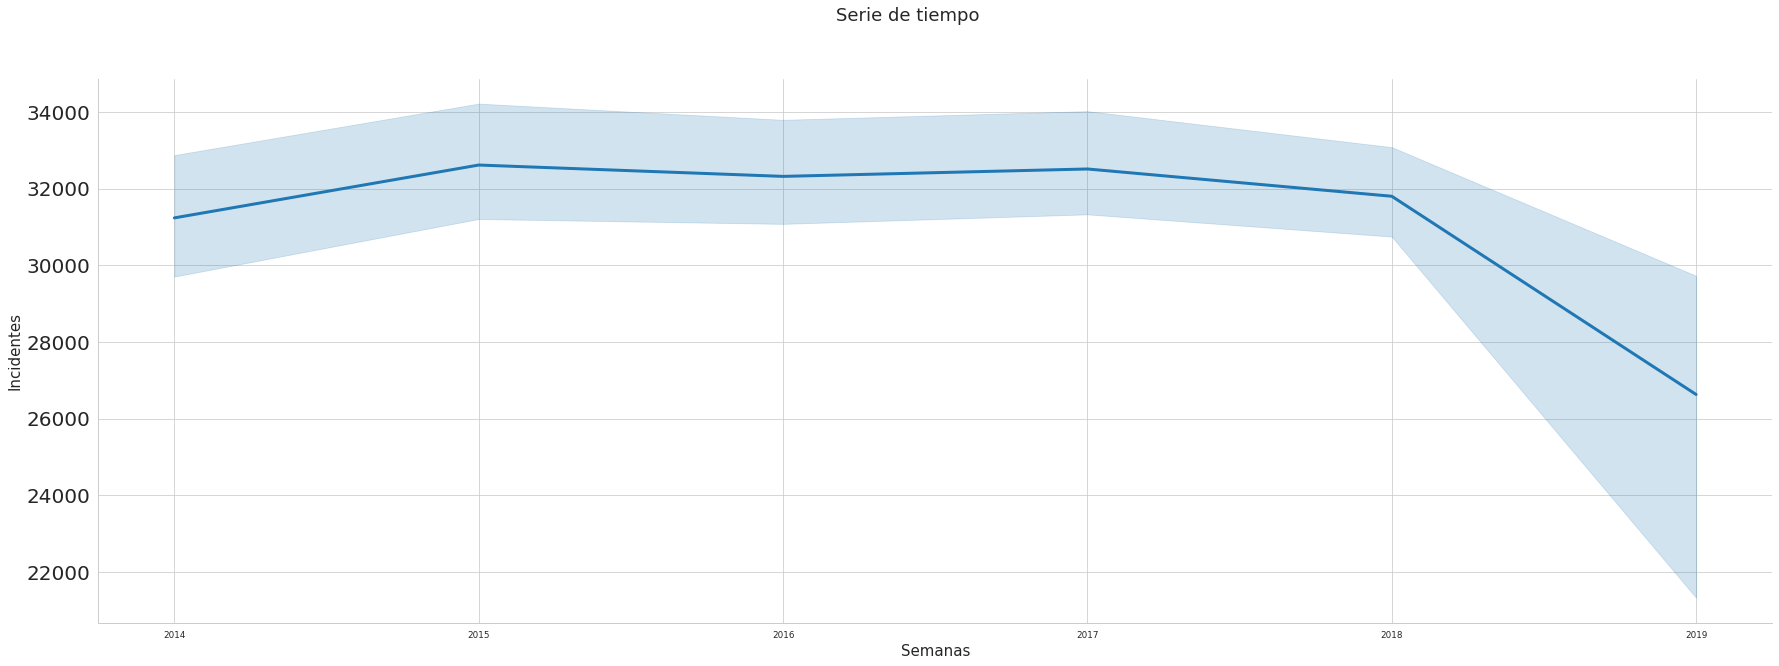

In [287]:
# plot
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
#sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
fig = plt.figure(figsize=(30,10))
fig.suptitle('Serie de tiempo')
sns.set_style("whitegrid")
lp = sns.lineplot(data=x, x=x.index, y='EVENTS', linewidth = 3)
#sns.scatterplot(data=dfweek, x=dfweek.index, y='COUNT', color='red', sizes=40)
lp.set(xlabel='Semanas', ylabel='Incidentes')
#plt.xticks(x.index(), x.ANIO, fontsize=20)
plt.yticks(fontsize=20)
sns.despine()
plt.show()

NameError: name 'dfp' is not defined

In [22]:
dfweek = data_time_series(1, 100, -74.07745119017216, 4.604447520159951, dfp)
dfweek

,COUNT
NSEM,
1,4
2,4
3,8
4,14
5,11
6,18
7,18
8,8
9,14


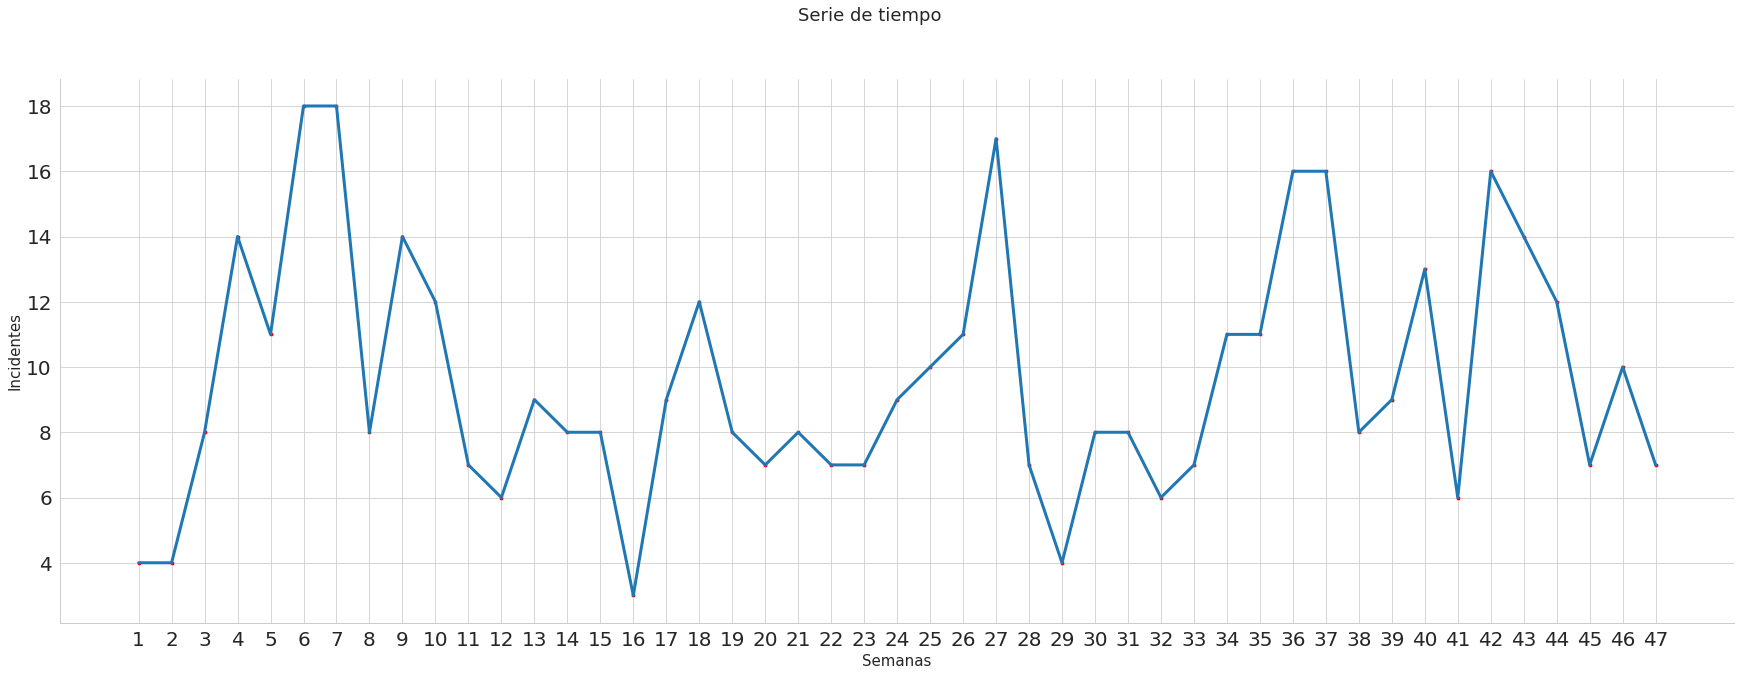

In [113]:
# plot
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
#sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
fig = plt.figure(figsize=(30,10))
fig.suptitle('Serie de tiempo')
sns.set_style("whitegrid")
lp = sns.lineplot(data=dfweek, x=dfweek.index, y='COUNT', linewidth = 3)
sns.scatterplot(data=dfweek, x=dfweek.index, y='COUNT', color='red', sizes=40)
lp.set(xlabel='Semanas', ylabel='Incidentes')
plt.xticks(dfweek.index.to_list(), dfweek.index.to_list(), fontsize=20)
plt.yticks(fontsize=20)
sns.despine()
plt.show()

In [432]:
x.groupby(['ANIO']).count().reset_index()

,ANIO,MES,EVENTS
0,2014,12,12
1,2015,12,12
2,2016,12,12
3,2017,12,12
4,2018,12,12
5,2019,12,12


In [530]:
x = data_series(dfp, 3,None, 2, None, None)


In [531]:
x

,ANIO,MES,DIA,DSEM,EVENTS
2,2014,1,1,2,3529.0
9,2014,1,2,2,0.0
16,2014,1,3,2,0.0
23,2014,1,4,2,0.0
30,2014,1,5,2,0.0
...,...,...,...,...,...
15591,2019,12,27,2,0.0
15598,2019,12,28,2,0.0
15605,2019,12,29,2,0.0
15612,2019,12,30,2,0.0


In [443]:
c = 0
l = list()
for i in range (0, 72):  
    if i == c:
        c = c + 12
        l.append('hola')
    else:
        l.append('')

In [445]:
len(l)

72